# DSAA5020 Group Project:
## Corporaci-n-Favorita-Grocery-Sales-Forecasting

## Task1- EDA-Part 1: EDA on Historical sales records in Train.csv

## 1. Preparation

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
import missingno as msno
import os
from subprocess import check_output
from tqdm.notebook import tqdm
import datetime
import calendar
from sort_dataframeby_monthorweek import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Memory Menagement
def calculate_memory_usage(df):
    memory = round(df.memory_usage(index=True).sum(), 3)
    return memory / 1024**2

# Reproducing from: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_memory_usage(df):
    """Reduce memory usage of DataFrame by modifying data types."""
    start_memory = df.memory_usage().sum() / 1024**2
    print('Initial Memory Usage: {:.3f} MB'.format(start_memory))
    
    for col in tqdm(df.columns):
        col_dtype = df[col].dtype
        
        if col_dtype != object and col_dtype.name != 'category' and 'datetime' not in col_dtype.name:
            min_val = df[col].min()
            max_val = df[col].max()
            
            if str(col_dtype)[:3] == 'int':
                int_types = [np.int8, np.int16, np.int32, np.int64]
                for int_type in int_types:
                    if min_val > np.iinfo(int_type).min and max_val < np.iinfo(int_type).max:
                        df[col] = df[col].astype(int_type)
                        break
            else:
                float_types = [np.float16, np.float32, np.float64]
                for float_type in float_types:
                    if min_val > np.finfo(float_type).min and max_val < np.finfo(float_type).max:
                        df[col] = df[col].astype(float_type)
                        break
        elif 'datetime' not in col_dtype.name:
            df[col] = df[col].astype('category')

    end_memory = df.memory_usage().sum() / 1024**2
    print('Memory after Optimization: {:.3f} MB'.format(end_memory))
    print('Reduced by {:.1f}%'.format(100 * (start_memory - end_memory) / start_memory))
    
    return df


## 2.  Load Data with Memory Menagement Methods

In [3]:
import gc
gc.collect()

0

In [5]:
# Reading and optimizing test data
test_file_path = '.\\raw_data\\test.csv'
df_test = pd.read_csv(test_file_path)

# Storing optimized data types of test dataframe for loading the train dataframe
dtypes_dict = dict(df_test.dtypes)
del dtypes_dict['date'], dtypes_dict['onpromotion']
del df_test
import gc
gc.collect()

0

In [6]:
# Loading train data with optimized data types from test dataframe
train_file_path = '.\\raw_data\\train.csv'
df_train = pd.read_csv(train_file_path, parse_dates=['date'], dtype=dtypes_dict)
print("Memory of Train Dataframe: %.3f MB" % calculate_memory_usage(df_train))

# Reducing memory usage of train dataframe
df_train = reduce_memory_usage(df_train)

Memory of Train Dataframe: 5744.799 MB
Initial Memory Usage: 5744.799 MB


  0%|          | 0/6 [00:00<?, ?it/s]

Memory after Optimization: 2633.033 MB
Reduced by 54.2%


In [7]:
import gc
gc.collect()

18

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int32         
 1   date         datetime64[ns]
 2   store_nbr    int8          
 3   item_nbr     int32         
 4   unit_sales   float32       
 5   onpromotion  category      
dtypes: category(1), datetime64[ns](1), float32(1), int32(2), int8(1)
memory usage: 2.6 GB


In [9]:
df_train

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True


## 3. Preprocessing

In [10]:
# Convert 'onpromotion' column to float and fill missing values with -1
df_train['onpromotion'] = df_train['onpromotion'].astype(float).fillna(-1)

In [11]:
import gc
gc.collect()

17

## 4. EDA

EDA from all features to label, with label:
$$y = unit\_sales$$

### (1) x = Store

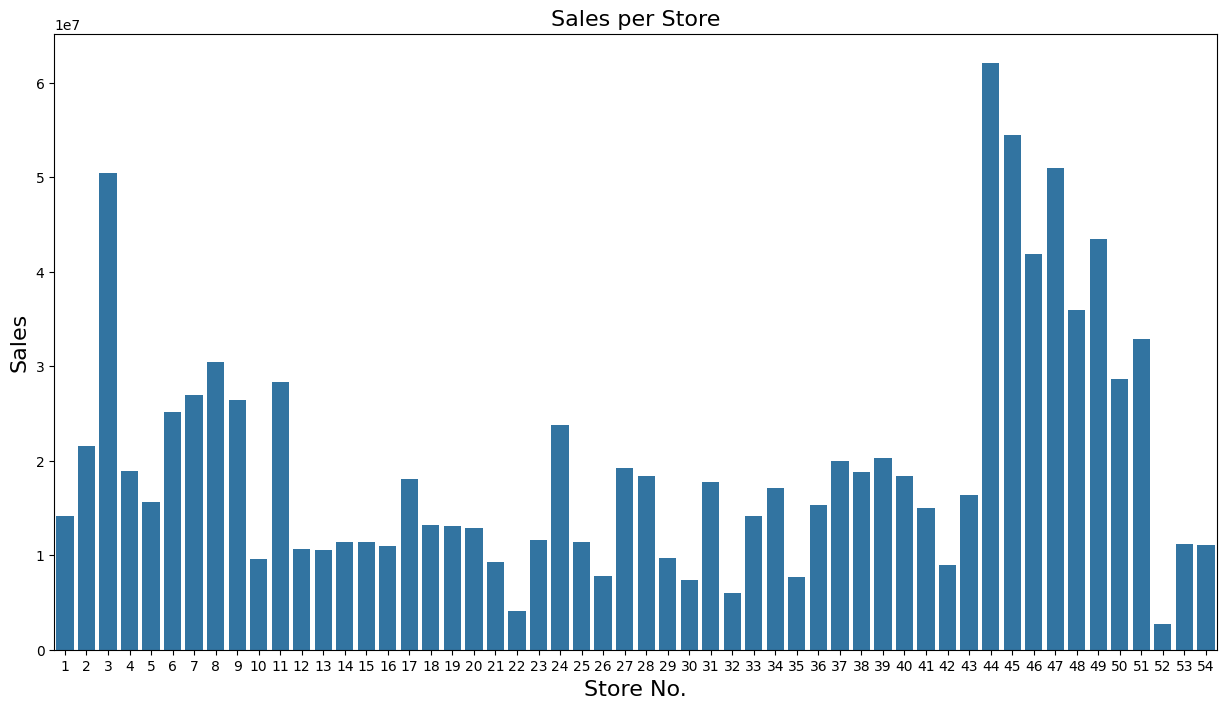

In [12]:
# Group by store_nbr and sum unit_sales for each store_nbr
sales_per_store = df_train.groupby(['store_nbr'], as_index=False).agg({'unit_sales': 'sum'}) 

# Plot store_nbr vs unit_sales
plt.figure(figsize=(15, 8))
sns.barplot(x='store_nbr', y='unit_sales', data=sales_per_store)
plt.title('Sales per Store', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store No.', fontsize=16)
plt.show()

In [13]:
import gc
gc.collect()

205

### (2) x =  Item

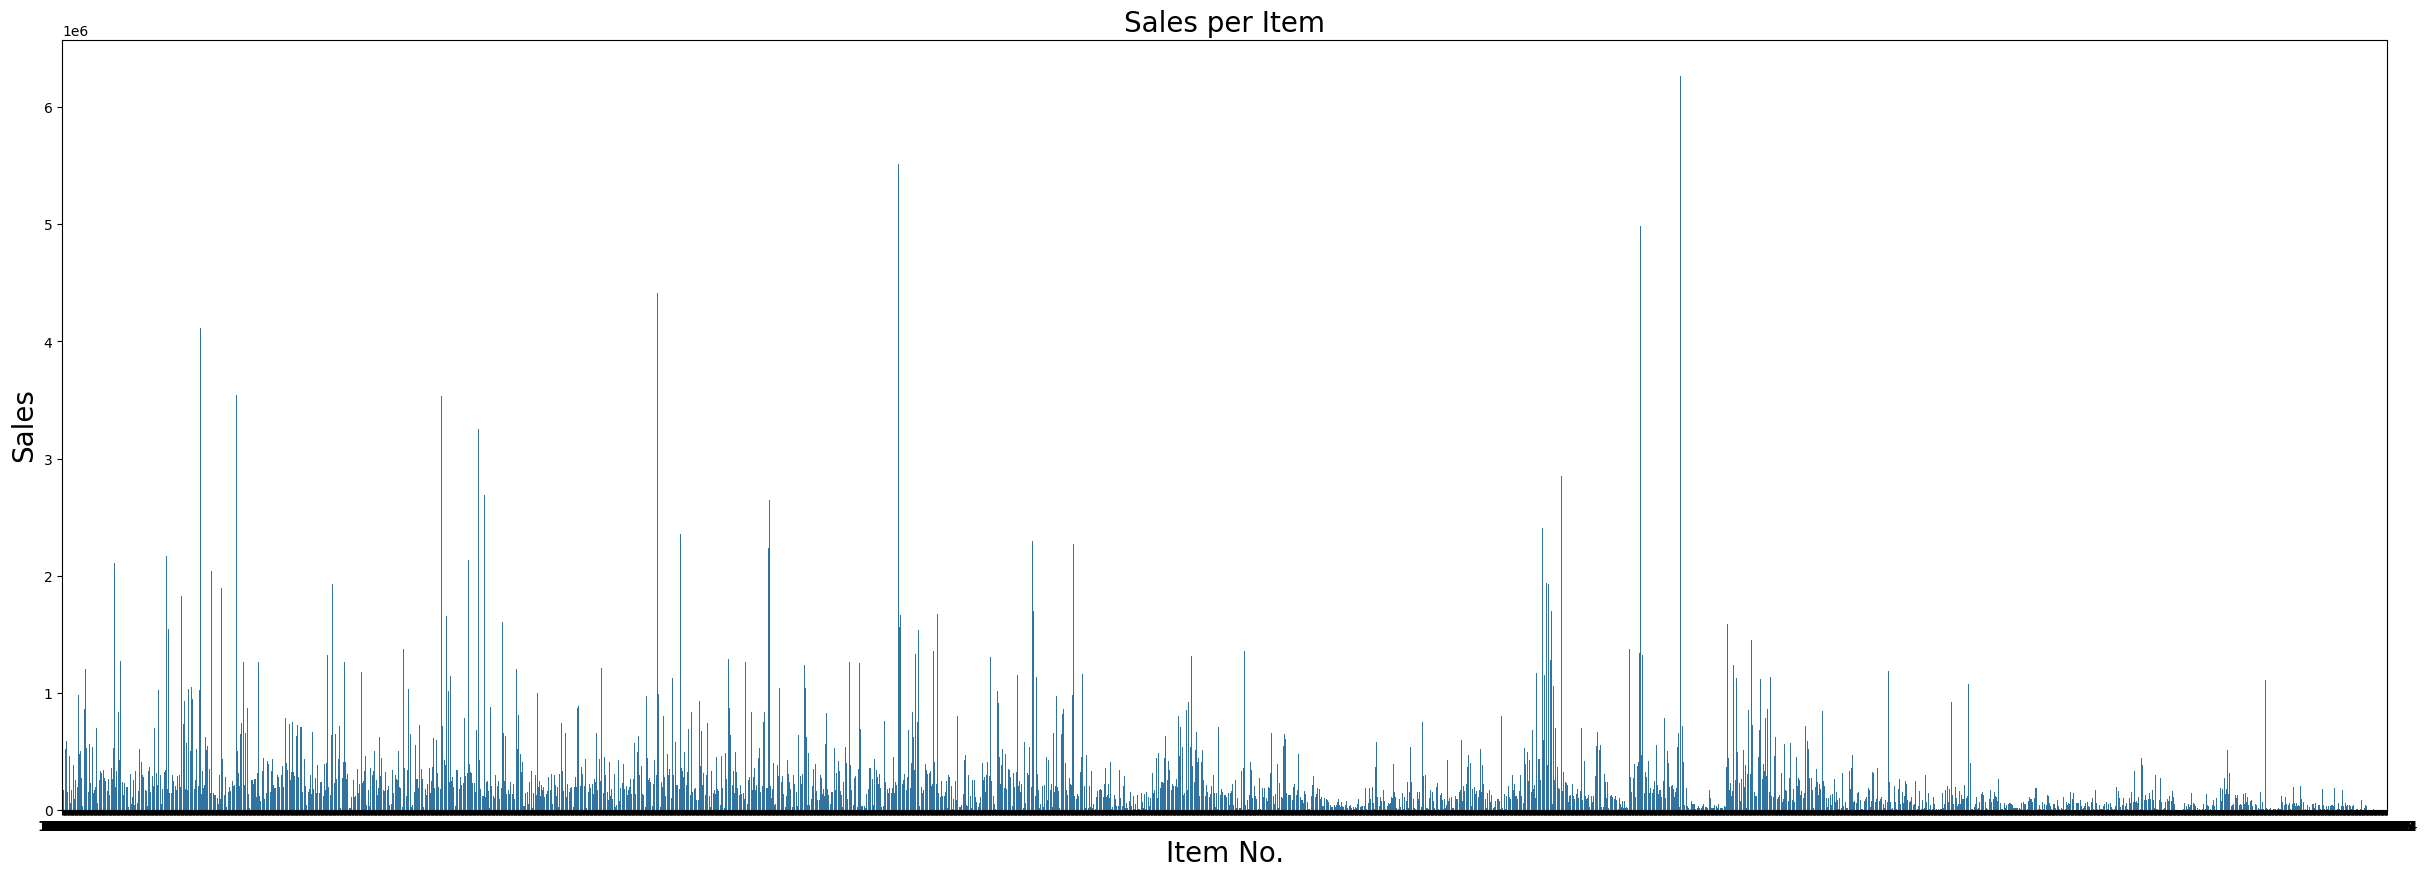

In [14]:
# Group by item_nbr and sum unit_sales for each item_nbr
sales_per_item = df_train.groupby(['item_nbr'], as_index=False).agg({'unit_sales': 'sum'}) 

# Plot item_nbr vs unit_sales
plt.figure(figsize=(30, 10))
sns.barplot(x='item_nbr', y='unit_sales', data=sales_per_item)
plt.title('Sales per Item', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.xlabel('Item No.', fontsize=20)
plt.show()

In [15]:
import gc
gc.collect()

155

### (3) x = year (Time Series Feature)

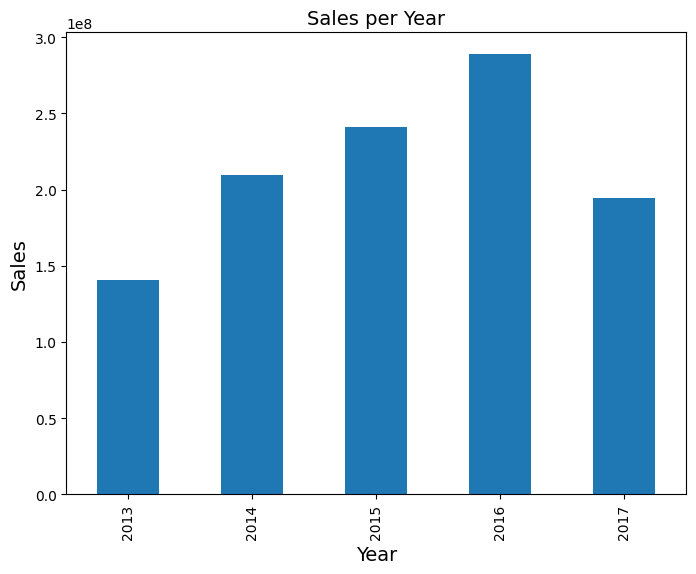

In [16]:
# Add 'year' as a feature and plot unit_sales per year
df_train["year"] = df_train["date"].dt.year
df_train.groupby(['year'])['unit_sales'].sum().plot(kind='bar', figsize=(8, 6))
plt.title('Sales per Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.show()

In [17]:
import gc
gc.collect()

930197

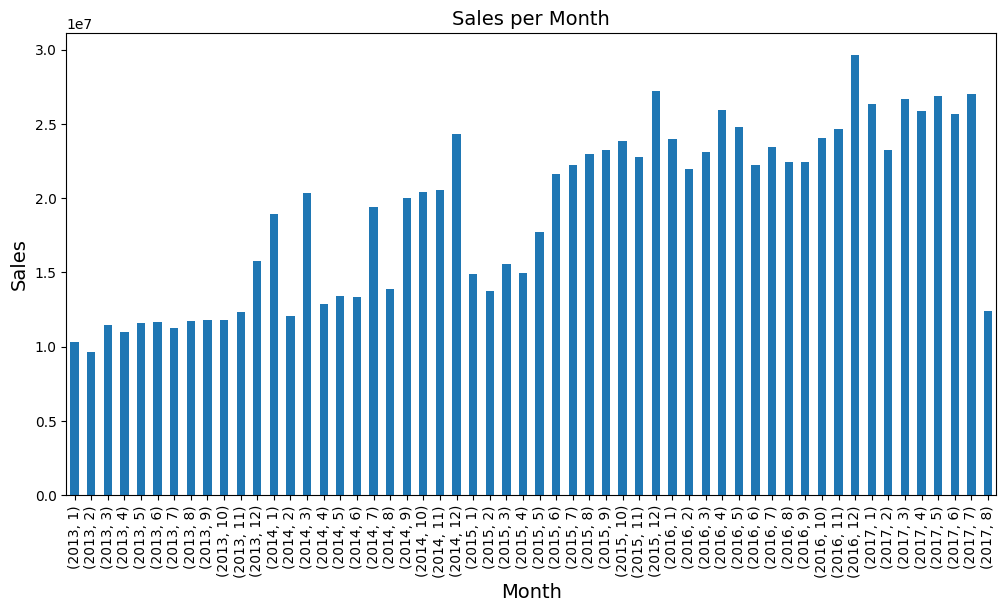

In [18]:
# Add 'year' and 'month' as features and plot unit_sales per month
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_train.groupby(['year', 'month'])['unit_sales'].sum().plot(kind='bar', figsize=(12, 6))
plt.title('Sales per Month', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.show()

In [19]:
import gc
gc.collect()

11519

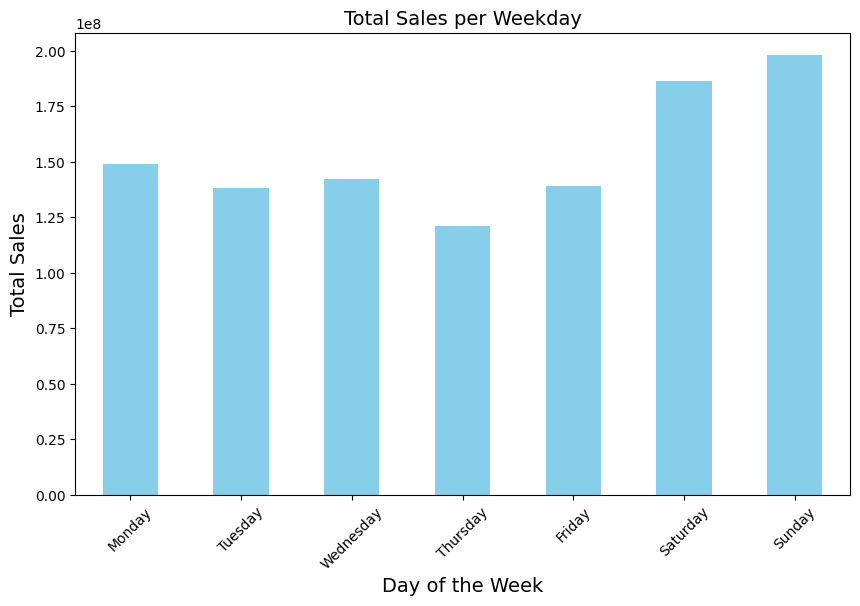

In [20]:
# Add 'weekday' as a feature and group by each day of the week to plot sales
df_train['weekday'] = df_train['date'].dt.dayofweek
sales_per_weekday = df_train.groupby('weekday')['unit_sales'].sum()

# Display a bar chart
sales_per_weekday.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Total Sales per Weekday', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.show()

In [21]:
del sales_per_weekday
import gc
gc.collect()

4047

### (4) x = onpromotion

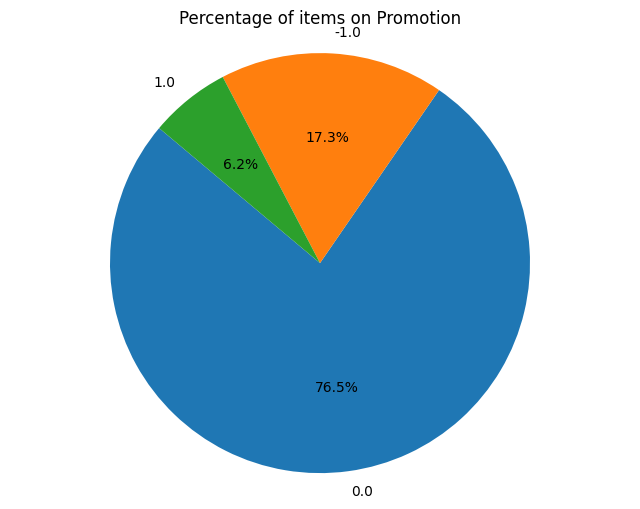

In [29]:
# Calculate the count of 'onpromotion' values
value_counts = df_train['onpromotion'].value_counts()

# Plot a pie chart to display the distribution of 'onpromotion' values
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of items on Promotion")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [28]:
del value_counts
import gc
gc.collect()

3190

Text(0, 0.5, 'Sales')

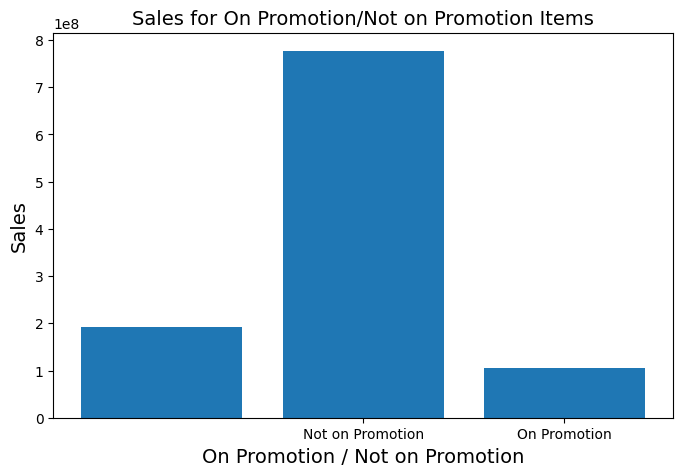

In [30]:
# Group by 'onpromotion' and calculate total unit_sales for each category
sales_per_promotion = df_train.groupby(['onpromotion'], as_index=False).agg({'unit_sales':'sum'})

# Plotting 'onpromotion' vs unit_sales
plt.figure(figsize=(8, 5))
plt.bar(sales_per_promotion['onpromotion'], sales_per_promotion['unit_sales'])
plt.title('Sales for On Promotion/Not on Promotion Items', fontsize=14)
plt.xticks([0, 1], ['Not on Promotion', 'On Promotion'])
plt.xlabel('On Promotion / Not on Promotion', fontsize=14)
plt.ylabel('Sales', fontsize=14)

In [31]:
del sales_per_promotion
import gc
gc.collect()

2616